In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import SVM_scripts as svm
import pickle
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import colorsys

In [ ]:
def adjust_saturation(color, factor=0.5):
    """
    Adjusts the saturation of a color.
    Args:
        color (str or tuple): A matplotlib color string, hex string, or RGB tuple.
        factor (float): A factor less than 1 reduces saturation, greater than 1 increases it.
    Returns:
        tuple: Color with adjusted saturation.
    """
    rgb = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    adjusted_rgb = colorsys.hls_to_rgb(h, l, max(0, min(s * factor, 1)))
    return adjusted_rgb

limit = 18
data_names = ['pgp-broccatelli', 'bbb-martins', 'ncats-solubility']
names = {'pgp-broccatelli': 'PGP (Broccatelli)', 'bbb-martins': 'BBB (Martins)', 'ncats-solubility': 'Solubility (Sun)'}
# colors = ["#1f77b4", '#ff7f0e', '#2ca02c']
colors = ['#005478', '#FBB906', '#BCCF0F', '#BA0051', '#47BCCD', '#DAD0B9']
#darkened_colors = [tuple(c * 0.9 for c in mcolors.to_rgb(color))  for color in colors]
#lightened_colors = [tuple((1 - 0.1) * c + 0.1 for c in mcolors.to_rgb(color)) for color in colors]
saturated_colors = [adjust_saturation(color, 1.15) for color in colors]
desaturated_colors = [adjust_saturation(color, 0.85) for color in colors]

Plot QA vs classical results:

C:\Users\oszal\AppData\Local\Temp\ipykernel_13056\1439124568.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


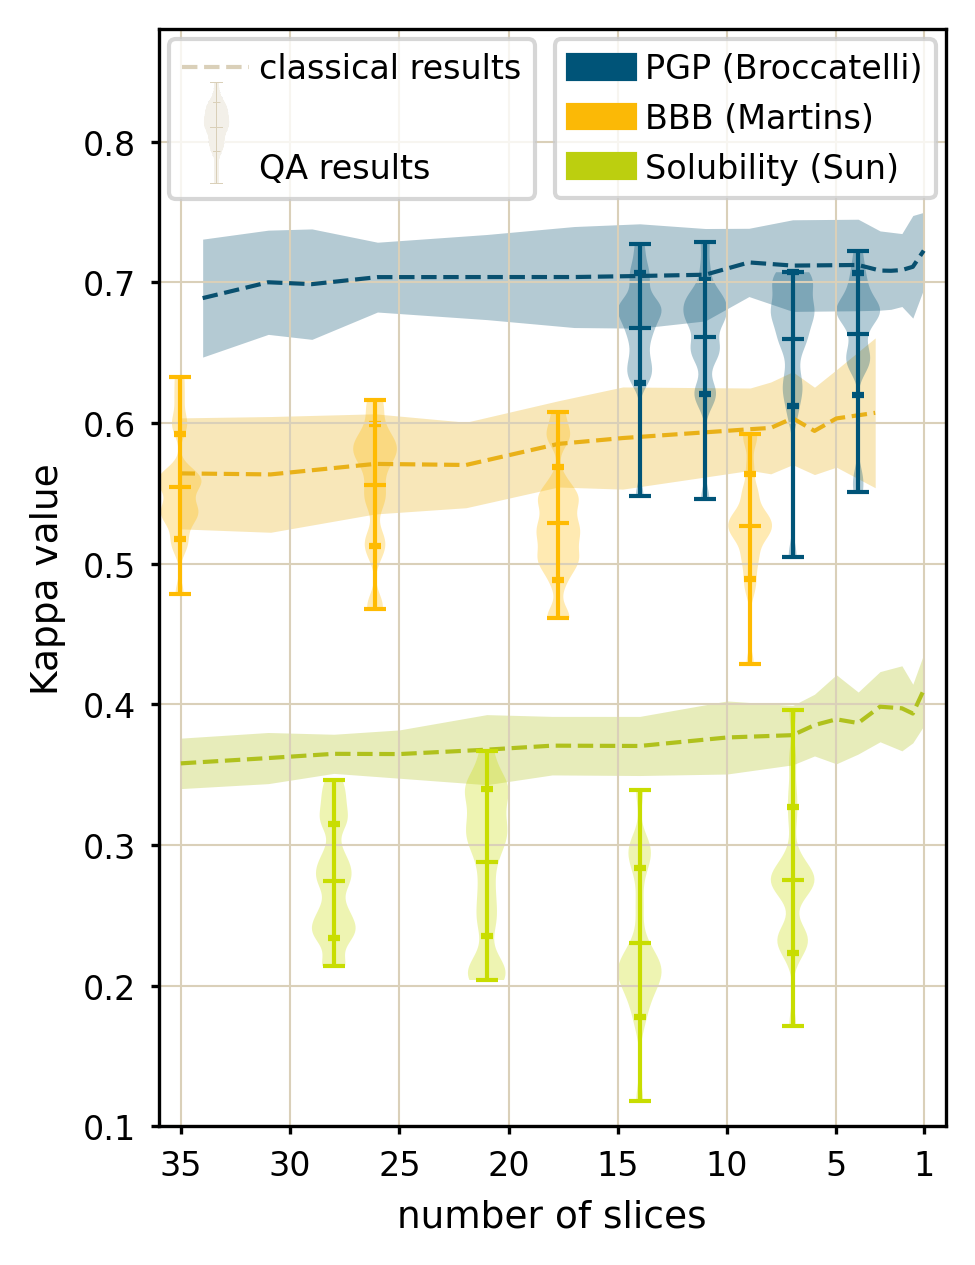

In [10]:
kappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[1] for data_name in data_names}
mean_limited_kappas = {data_name: {slice_size: np.mean(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
std_limited_kappas = {data_name: {slice_size: np.std(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
slice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[0] for data_name in data_names}

qkappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_QA.pkl')[4]['more_shots'] for data_name in data_names}
qkappas = {data_name: {slice_size: kappa for slice_size, kappa in qkappas[data_name].items() if len(kappa) >= limit} for data_name in data_names} # only take sufficiently large data
qmean_limited_kappas = {data_name: {slice_size: np.mean([k for k in kappa[:limit] if k is not None]) for slice_size, kappa in qkappas[data_name].items()} for data_name in data_names}
qstd_limited_kappas = {data_name: {slice_size: np.std([k for k in kappa[:limit] if k is not None]) for slice_size, kappa in qkappas[data_name].items()} for data_name in data_names}
qslice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_QA.pkl')[0] for data_name in data_names}

# slice_size_to_slices = {data_name: {} for data_name in data_names}
# for data_name in data_names:
#     for slice_size in kappas[data_name].keys():
#         num_slices, num_fold_slices = [], []
#         for vectors, labels, test_vectors, test_labels in slice_study_results[data_name]['data_sets'][:limit]:
#             slices, slice_labels, counts = svm.slice_training_data(vectors, labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_slices += [len(slices)]
#             fold_vectors, fold_labels, fold_test_vectors, fold_test_labels = svm.prepare_data_sets(vectors, labels, train_percentage=75, positive_negative_ratio=None, max_train_size=None, min_train_size=None, seed=0, normalize_data=True, print_info=False)
#             fold_slices, fold_slice_labels, fold_counts = svm.slice_training_data(fold_vectors, fold_labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_fold_slices += [len(fold_slices)]
#             slice_size_to_slices[data_name][slice_size] = num_slices, num_fold_slices
# with open('results/slice_size_to_num_slices.pkl','wb') as f:
#     pickle.dump(slice_size_to_slices, f)
    
with open('results/slice_size_to_num_slices.pkl', 'rb') as file:
    slice_size_to_slices = pickle.load(file)
slice_size_to_mean_slices = {data_name:{slice_size: np.mean(num_slices[0][:limit]) for slice_size, num_slices in slice_converter.items()} for data_name, slice_converter in slice_size_to_slices.items()}
# adjust cases where the number of slices stays the same (split by number of foldslices then):
for data_name in data_names:
    previous_mean_slice = 0
    for slice_size in slice_size_to_mean_slices[data_name].keys():
        if slice_size_to_mean_slices[data_name][slice_size] == previous_mean_slice:
            slice_size_to_mean_slices[data_name][slice_size] = np.mean([slice_size_to_mean_slices[data_name][slice_size], np.mean(slice_size_to_slices[data_name][slice_size][1][:limit])])
        previous_mean_slice = slice_size_to_mean_slices[data_name][slice_size]
labels, color_labels = [], []
fig, ax = plt.subplots(1,1, figsize=(85.937e-1 / 2.54, 4.75), dpi=300)
for i, data_name in enumerate(data_names): # plot classical
    x, y = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in mean_limited_kappas[data_name].items()])
    y_std = [std_kappa for slice_size, std_kappa in std_limited_kappas[data_name].items()]
    ax.plot(x,y, linestyle='dashed', color=desaturated_colors[i], lw=1) # label=data_name + ' (classical results)'
    ax.fill_between(x, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std),alpha=0.3, color=desaturated_colors[i], linewidth=0.0)
    # ax.scatter(x,y, marker="^", color=c, s=10)

for i, data_name in enumerate(data_names): # plot quantum
    qx, qy = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in qmean_limited_kappas[data_name].items()])
    qy_std = [std_kappa for slice_size, std_kappa in qstd_limited_kappas[data_name].items()]
    violin_data = [[k for k in kappa[:limit] if k is not None] for slice_size, kappa in qkappas[data_name].items()]
    violin_parts = ax.violinplot(dataset=violin_data, positions=qx, bw_method=0.2, showmeans=True, widths=2)
    for pc in violin_parts['bodies']:
        pc.set_facecolor(saturated_colors[i])
        #pc.set_edgecolor('red')
        # pc.set_linewidth(1)
    for violin_key in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        violin_parts[violin_key].set_color(saturated_colors[i])
        violin_parts[violin_key].set_linewidth(1)
        
    ax.scatter(qx*2, np.append(np.array(qy) + np.array(qy_std), np.array(qy) - np.array(qy_std)), marker="_", s=9, color=saturated_colors[i])

    color_labels.append((mpatches.Patch(color=colors[i]), names[data_name]))
    # plt.plot(qx,qy, label=data_name, color=c)
    # plt.fill_between(qx, np.array(qy) - np.array(qy_std), np.array(qy) + np.array(qy_std), alpha=0.3, color=c)
# plt.plot([35], [0.7], linestyle='solid', c='grey', label='quantum results') # for legend
# plt.plot([35], [0.7], linestyle='dashed', c='grey', label='classical results') # for legend
# labels.append((mpatches.Patch(facecolor='gray', edgecolor='red'), 'quantum results'))
labels.append((Line2D([0], [0], color=colors[-1], linestyle='dashed', lw=1), 'classical results'))
violin_img = OffsetImage(plt.imread('violin_icon_gray.png'), zoom=0.0315)
labels.append((violin_img, 'QA results'))
class HandlerImage:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        ab = AnnotationBbox(violin_img, (33.4, 0.805), frameon=False, pad=0)
        handlebox.add_artist(ab)
        return ab
# plt.xscale('log')
color_legend = plt.legend(*zip(*color_labels), loc='upper right', fontsize=8, handletextpad=0.3, borderaxespad=0.3)
ax.set_xticks(ticks=[1]+list(range(5, 40, 5)))
ax.tick_params(axis='both', labelsize=8, length=2)
ax.invert_xaxis()
ax.grid(color=colors[-1], linewidth=0.5)
ax.set_xlabel('number of slices', fontsize=9)
ax.set_ylabel('Kappa value', fontsize=9)
ax.add_artist(color_legend)
ax.legend(*zip(*labels), loc='upper left', labelspacing = 2, fontsize=8, handler_map={OffsetImage: HandlerImage()}, handletextpad=0.3, borderaxespad=0.3)
ax.set_xlim([36, 0])
ax.set_ylim([0.1, 0.88])
#fig.savefig('classical_SA_kappas_plot' + '.png', dpi=300, bbox_inches='tight')
fig.show()

Plot SA limited vs classical results:

C:\Users\oszal\AppData\Local\Temp\ipykernel_13056\1848273082.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


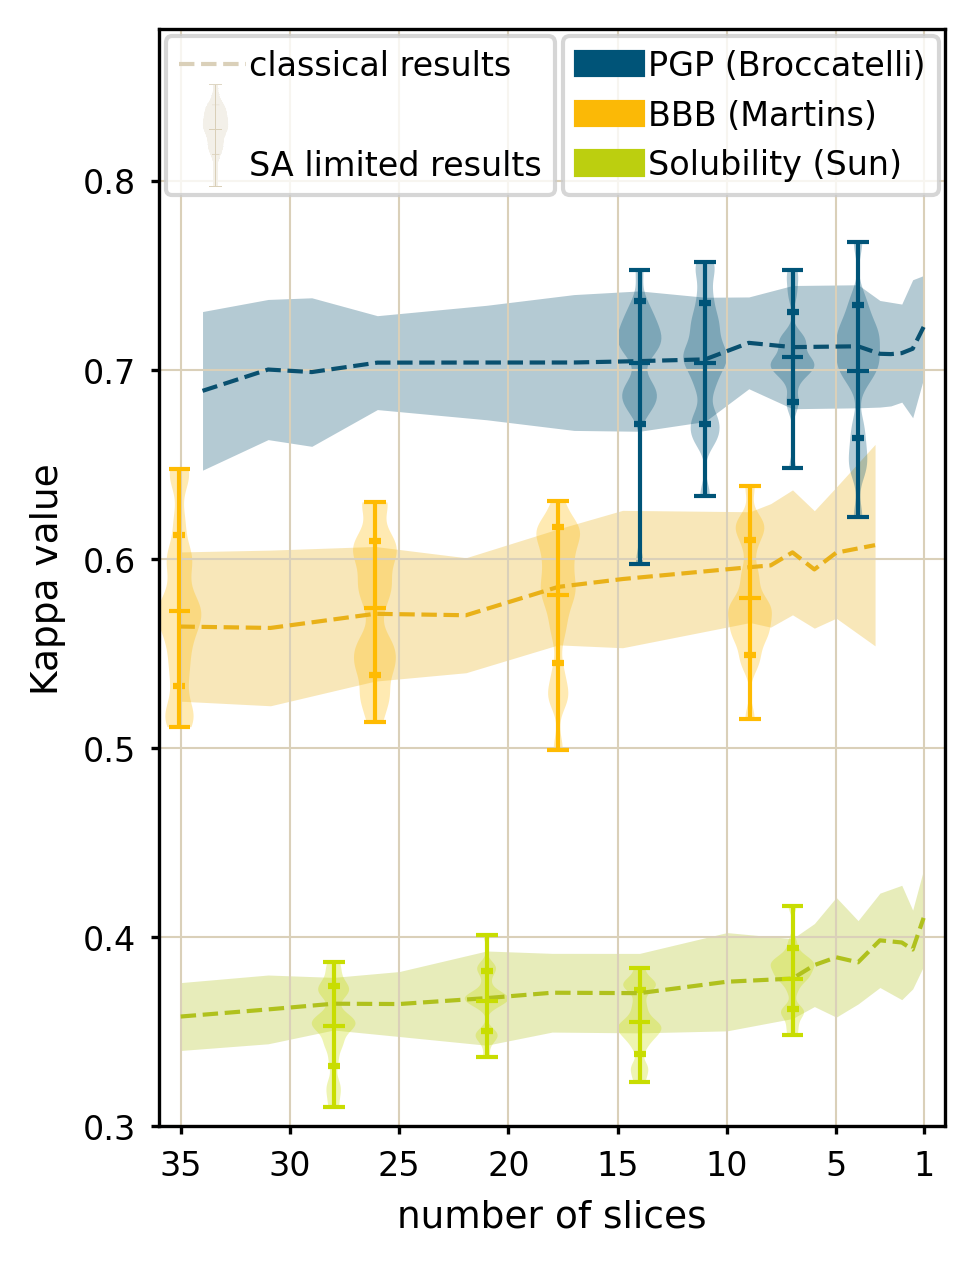

In [17]:
kappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[1] for data_name in data_names}
mean_limited_kappas = {data_name: {slice_size: np.mean(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
std_limited_kappas = {data_name: {slice_size: np.std(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
slice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[0] for data_name in data_names}

qkappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_SA_limited.pkl')[4]['more_shots'] for data_name in data_names}
qkappas = {data_name: {slice_size: kappa for slice_size, kappa in qkappas[data_name].items() if len(kappa) >= limit} for data_name in data_names} # only take sufficiently large data
qmean_limited_kappas = {data_name: {slice_size: np.mean([k for k in kappa[:limit] if k is not None]) for slice_size, kappa in qkappas[data_name].items()} for data_name in data_names}
qstd_limited_kappas = {data_name: {slice_size: np.std([k for k in kappa[:limit] if k is not None]) for slice_size, kappa in qkappas[data_name].items()} for data_name in data_names}
qslice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_SA_limited.pkl')[0] for data_name in data_names}

# slice_size_to_slices = {data_name: {} for data_name in data_names}
# for data_name in data_names:
#     for slice_size in kappas[data_name].keys():
#         num_slices, num_fold_slices = [], []
#         for vectors, labels, test_vectors, test_labels in slice_study_results[data_name]['data_sets'][:limit]:
#             slices, slice_labels, counts = svm.slice_training_data(vectors, labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_slices += [len(slices)]
#             fold_vectors, fold_labels, fold_test_vectors, fold_test_labels = svm.prepare_data_sets(vectors, labels, train_percentage=75, positive_negative_ratio=None, max_train_size=None, min_train_size=None, seed=0, normalize_data=True, print_info=False)
#             fold_slices, fold_slice_labels, fold_counts = svm.slice_training_data(fold_vectors, fold_labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_fold_slices += [len(fold_slices)]
#             slice_size_to_slices[data_name][slice_size] = num_slices, num_fold_slices
# with open('results/slice_size_to_num_slices.pkl','wb') as f:
#     pickle.dump(slice_size_to_slices, f)
    
with open('results/slice_size_to_num_slices.pkl', 'rb') as file:
    slice_size_to_slices = pickle.load(file)
slice_size_to_mean_slices = {data_name:{slice_size: np.mean(num_slices[0][:limit]) for slice_size, num_slices in slice_converter.items()} for data_name, slice_converter in slice_size_to_slices.items()}
# adjust cases where the number of slices stays the same (split by number of foldslices then):
for data_name in data_names:
    previous_mean_slice = 0
    for slice_size in slice_size_to_mean_slices[data_name].keys():
        if slice_size_to_mean_slices[data_name][slice_size] == previous_mean_slice:
            slice_size_to_mean_slices[data_name][slice_size] = np.mean([slice_size_to_mean_slices[data_name][slice_size], np.mean(slice_size_to_slices[data_name][slice_size][1][:limit])])
        previous_mean_slice = slice_size_to_mean_slices[data_name][slice_size]
labels, color_labels = [], []
fig, ax = plt.subplots(1,1, figsize=(85.937e-1 / 2.54, 4.75), dpi=300)
for i, data_name in enumerate(data_names): # plot classical
    x, y = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in mean_limited_kappas[data_name].items()])
    y_std = [std_kappa for slice_size, std_kappa in std_limited_kappas[data_name].items()]
    ax.plot(x,y, linestyle='dashed', color=desaturated_colors[i], lw=1) # label=data_name + ' (classical results)'
    ax.fill_between(x, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std),alpha=0.3, color=desaturated_colors[i], linewidth=0.0)
    # ax.scatter(x,y, marker="^", color=c, s=10)

for i, data_name in enumerate(data_names): # plot quantum
    qx, qy = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in qmean_limited_kappas[data_name].items()])
    qy_std = [std_kappa for slice_size, std_kappa in qstd_limited_kappas[data_name].items()]
    violin_data = [[k for k in kappa[:limit] if k is not None] for slice_size, kappa in qkappas[data_name].items()]
    violin_parts = ax.violinplot(dataset=violin_data, positions=qx, bw_method=0.2, showmeans=True, widths=2)
    for pc in violin_parts['bodies']:
        pc.set_facecolor(saturated_colors[i])
        #pc.set_edgecolor('red')
        # pc.set_linewidth(1)
    for violin_key in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        violin_parts[violin_key].set_color(saturated_colors[i])
        violin_parts[violin_key].set_linewidth(1)
        
    ax.scatter(qx*2, np.append(np.array(qy) + np.array(qy_std), np.array(qy) - np.array(qy_std)), marker="_", s=9, color=saturated_colors[i])

    color_labels.append((mpatches.Patch(color=colors[i]), names[data_name]))
    # plt.plot(qx,qy, label=data_name, color=c)
    # plt.fill_between(qx, np.array(qy) - np.array(qy_std), np.array(qy) + np.array(qy_std), alpha=0.3, color=c)
# plt.plot([35], [0.7], linestyle='solid', c='grey', label='quantum results') # for legend
# plt.plot([35], [0.7], linestyle='dashed', c='grey', label='classical results') # for legend
# labels.append((mpatches.Patch(facecolor='gray', edgecolor='red'), 'quantum results'))
labels.append((Line2D([0], [0], color=colors[-1], linestyle='dashed', lw=1), 'classical results'))
violin_img = OffsetImage(plt.imread('violin_icon_gray.png'), zoom=0.032)
labels.append((violin_img, 'SA limited results'))
class HandlerImage:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        ab = AnnotationBbox(violin_img, (33.4, 0.823), frameon=False, pad=0)
        handlebox.add_artist(ab)
        return ab
# plt.xscale('log')
color_legend = plt.legend(*zip(*color_labels), loc='upper right', fontsize=8, handletextpad=0.15, borderaxespad=0.2)
ax.set_xticks(ticks=[1]+list(range(5, 40, 5)))
ax.tick_params(axis='both', labelsize=8, length=2)
ax.invert_xaxis()
ax.grid(color=colors[-1], linewidth=0.5)
ax.set_xlabel('number of slices', fontsize=9)
ax.set_ylabel('Kappa value', fontsize=9)
ax.add_artist(color_legend)
ax.legend(*zip(*labels), loc='upper left', labelspacing = 2, fontsize=8, handler_map={OffsetImage: HandlerImage()}, handletextpad=0.1, borderaxespad=0.2)
ax.set_xlim([36, 0])
ax.set_ylim([0.3, 0.88])
#fig.savefig('classical_SA_kappas_plot' + '.png', dpi=300, bbox_inches='tight')
fig.show()

Plot SA unlimited vs classical results:

C:\Users\oszal\AppData\Local\Temp\ipykernel_13056\3233579395.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


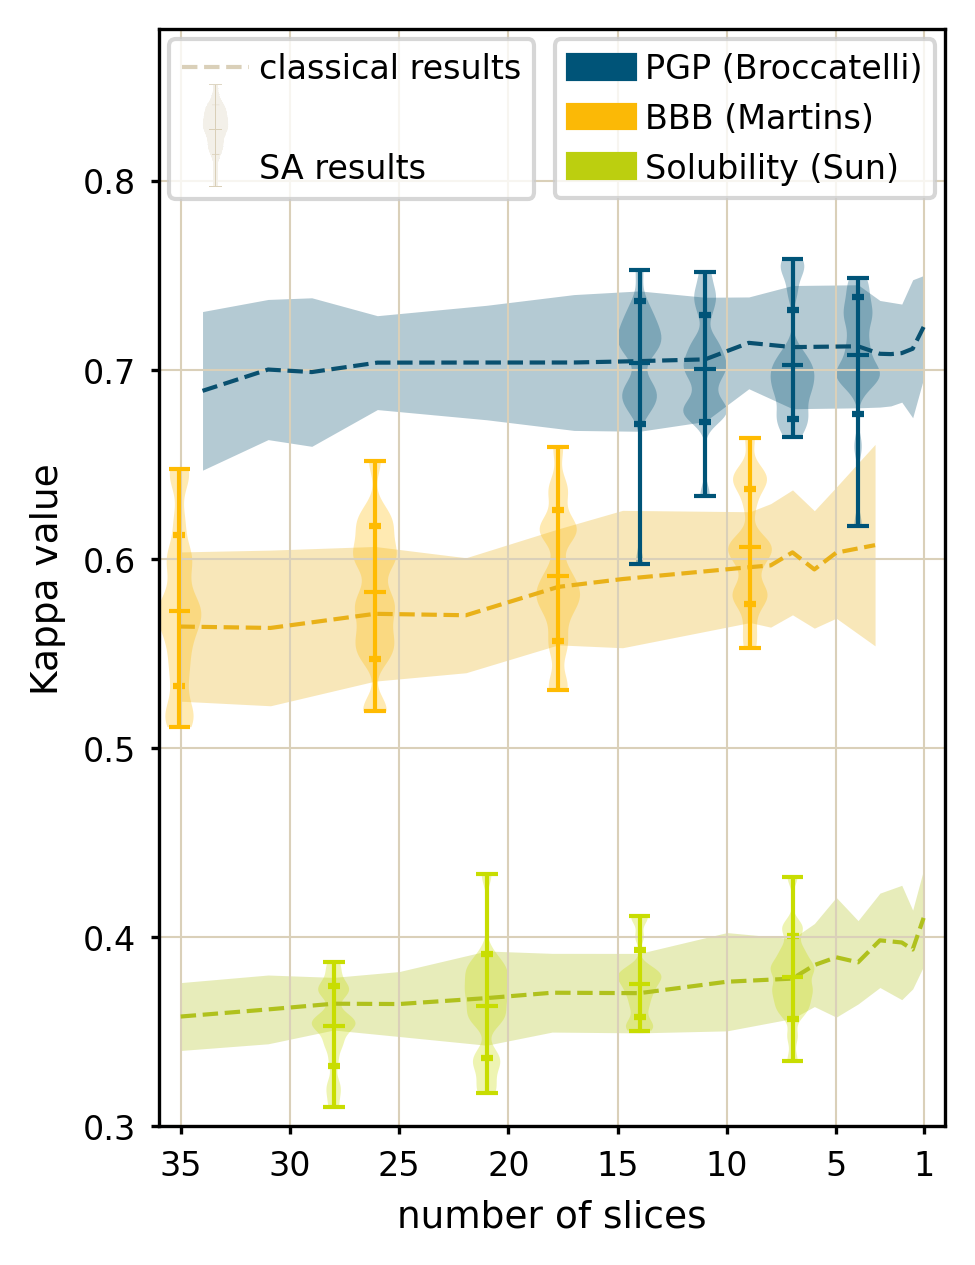

In [21]:
kappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[1] for data_name in data_names}
mean_limited_kappas = {data_name: {slice_size: np.mean(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
std_limited_kappas = {data_name: {slice_size: np.std(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
slice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[0] for data_name in data_names}

qkappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_SA.pkl')[4]['more_shots'] for data_name in data_names}
qkappas = {data_name: {slice_size: kappa for slice_size, kappa in qkappas[data_name].items() if len(kappa) >= limit} for data_name in data_names} # only take sufficiently large data
qmean_limited_kappas = {data_name: {slice_size: np.mean([k for k in kappa[:limit] if k is not None]) for slice_size, kappa in qkappas[data_name].items()} for data_name in data_names}
qstd_limited_kappas = {data_name: {slice_size: np.std([k for k in kappa[:limit] if k is not None]) for slice_size, kappa in qkappas[data_name].items()} for data_name in data_names}
qslice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_SA.pkl')[0] for data_name in data_names}

# slice_size_to_slices = {data_name: {} for data_name in data_names}
# for data_name in data_names:
#     for slice_size in kappas[data_name].keys():
#         num_slices, num_fold_slices = [], []
#         for vectors, labels, test_vectors, test_labels in slice_study_results[data_name]['data_sets'][:limit]:
#             slices, slice_labels, counts = svm.slice_training_data(vectors, labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_slices += [len(slices)]
#             fold_vectors, fold_labels, fold_test_vectors, fold_test_labels = svm.prepare_data_sets(vectors, labels, train_percentage=75, positive_negative_ratio=None, max_train_size=None, min_train_size=None, seed=0, normalize_data=True, print_info=False)
#             fold_slices, fold_slice_labels, fold_counts = svm.slice_training_data(fold_vectors, fold_labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_fold_slices += [len(fold_slices)]
#             slice_size_to_slices[data_name][slice_size] = num_slices, num_fold_slices
# with open('results/slice_size_to_num_slices.pkl','wb') as f:
#     pickle.dump(slice_size_to_slices, f)
    
with open('results/slice_size_to_num_slices.pkl', 'rb') as file:
    slice_size_to_slices = pickle.load(file)
slice_size_to_mean_slices = {data_name:{slice_size: np.mean(num_slices[0][:limit]) for slice_size, num_slices in slice_converter.items()} for data_name, slice_converter in slice_size_to_slices.items()}
# adjust cases where the number of slices stays the same (split by number of foldslices then):
for data_name in data_names:
    previous_mean_slice = 0
    for slice_size in slice_size_to_mean_slices[data_name].keys():
        if slice_size_to_mean_slices[data_name][slice_size] == previous_mean_slice:
            slice_size_to_mean_slices[data_name][slice_size] = np.mean([slice_size_to_mean_slices[data_name][slice_size], np.mean(slice_size_to_slices[data_name][slice_size][1][:limit])])
        previous_mean_slice = slice_size_to_mean_slices[data_name][slice_size]
labels, color_labels = [], []
fig, ax = plt.subplots(1,1, figsize=(85.937e-1 / 2.54, 4.75), dpi=300)
for i, data_name in enumerate(data_names): # plot classical
    x, y = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in mean_limited_kappas[data_name].items()])
    y_std = [std_kappa for slice_size, std_kappa in std_limited_kappas[data_name].items()]
    ax.plot(x,y, linestyle='dashed', color=desaturated_colors[i], lw=1) # label=data_name + ' (classical results)'
    ax.fill_between(x, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std),alpha=0.3, color=desaturated_colors[i], linewidth=0.0)
    # ax.scatter(x,y, marker="^", color=c, s=10)

for i, data_name in enumerate(data_names): # plot quantum
    qx, qy = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in qmean_limited_kappas[data_name].items()])
    qy_std = [std_kappa for slice_size, std_kappa in qstd_limited_kappas[data_name].items()]
    violin_data = [[k for k in kappa[:limit] if k is not None] for slice_size, kappa in qkappas[data_name].items()]
    violin_parts = ax.violinplot(dataset=violin_data, positions=qx, bw_method=0.2, showmeans=True, widths=2)
    for pc in violin_parts['bodies']:
        pc.set_facecolor(saturated_colors[i])
        #pc.set_edgecolor('red')
        # pc.set_linewidth(1)
    for violin_key in ['cbars', 'cmins', 'cmaxes', 'cmeans']:
        violin_parts[violin_key].set_color(saturated_colors[i])
        violin_parts[violin_key].set_linewidth(1)
        
    ax.scatter(qx*2, np.append(np.array(qy) + np.array(qy_std), np.array(qy) - np.array(qy_std)), marker="_", s=9, color=saturated_colors[i])

    color_labels.append((mpatches.Patch(color=colors[i]), names[data_name]))
    # plt.plot(qx,qy, label=data_name, color=c)
    # plt.fill_between(qx, np.array(qy) - np.array(qy_std), np.array(qy) + np.array(qy_std), alpha=0.3, color=c)
# plt.plot([35], [0.7], linestyle='solid', c='grey', label='quantum results') # for legend
# plt.plot([35], [0.7], linestyle='dashed', c='grey', label='classical results') # for legend
# labels.append((mpatches.Patch(facecolor='gray', edgecolor='red'), 'quantum results'))
labels.append((Line2D([0], [0], color=colors[-1], linestyle='dashed', lw=1), 'classical results'))
violin_img = OffsetImage(plt.imread('violin_icon_gray.png'), zoom=0.032)
labels.append((violin_img, 'SA results'))
class HandlerImage:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        ab = AnnotationBbox(violin_img, (33.4, 0.823), frameon=False, pad=0)
        handlebox.add_artist(ab)
        return ab
# plt.xscale('log')
color_legend = plt.legend(*zip(*color_labels), loc='upper right', fontsize=8, handletextpad=0.3, borderaxespad=0.3)
ax.set_xticks(ticks=[1]+list(range(5, 40, 5)))
ax.tick_params(axis='both', labelsize=8, length=2)
ax.invert_xaxis()
ax.grid(color=colors[-1], linewidth=0.5)
ax.set_xlabel('number of slices', fontsize=9)
ax.set_ylabel('Kappa value', fontsize=9)
ax.add_artist(color_legend)
ax.legend(*zip(*labels), loc='upper left', labelspacing = 2, fontsize=8, handler_map={OffsetImage: HandlerImage()}, handletextpad=0.3, borderaxespad=0.3)
ax.set_xlim([36, 0])
ax.set_ylim([0.3, 0.88])
# fig.savefig('classical_SA_kappas_plot' + '.png', dpi=300, bbox_inches='tight')
fig.show()

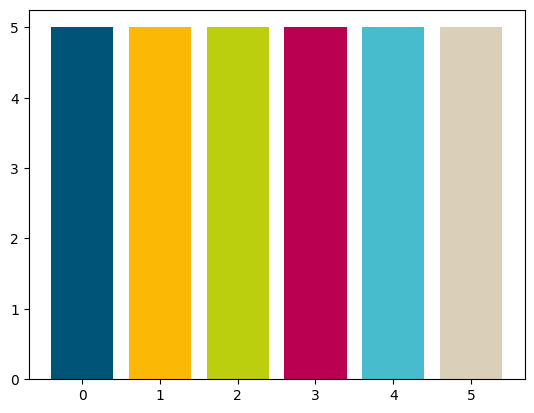

In [36]:
for i, c in enumerate(colors):
    plt.bar(i,5,color=c)
plt.savefig('color_palette.png', dpi=200)
plt.show()

Plot Classical results only

C:\Users\oszal\AppData\Local\Temp\ipykernel_13056\920259600.py:77: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


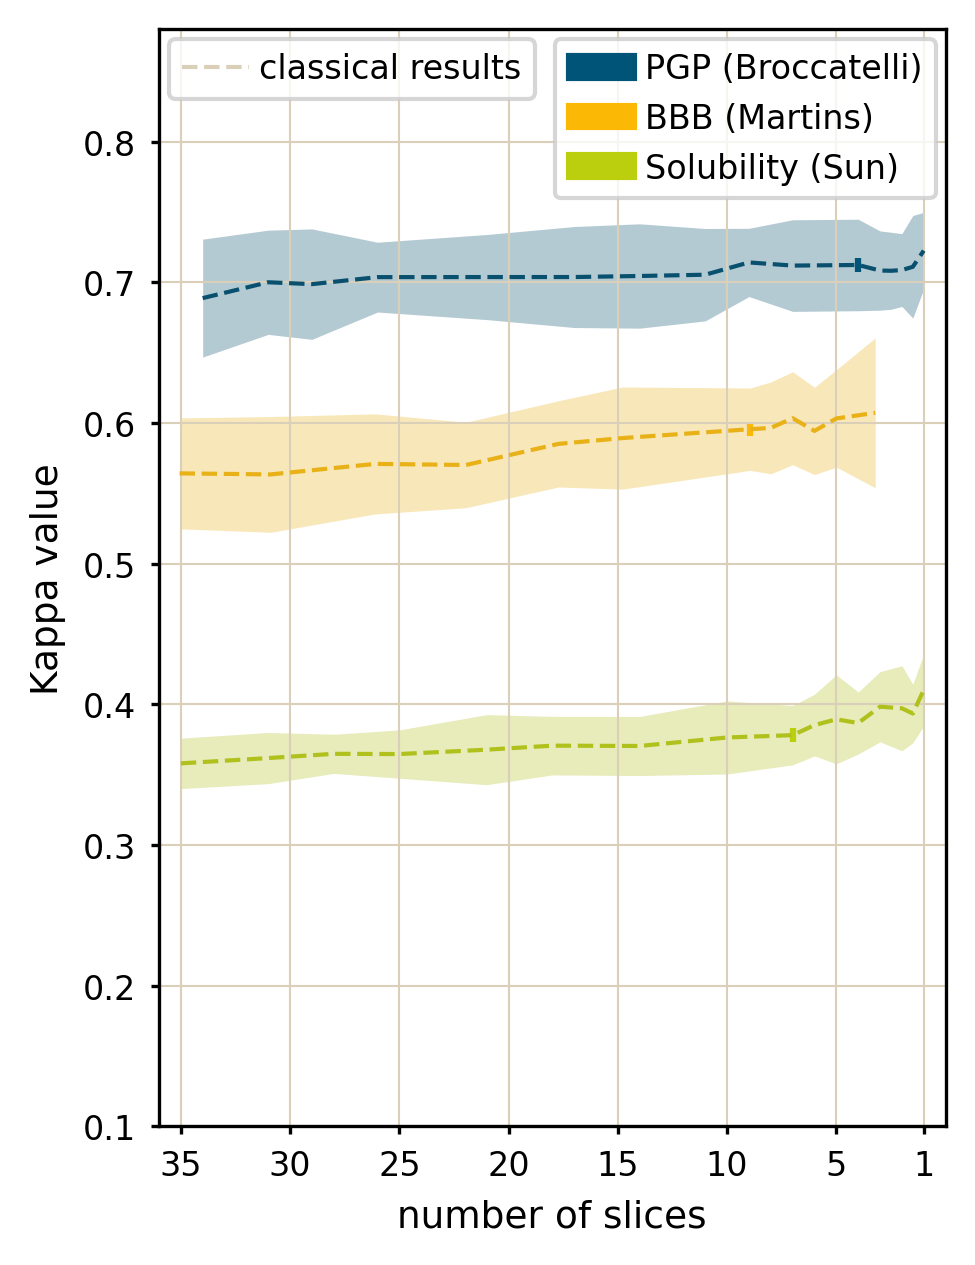

In [22]:
limit = 18
data_names = ['pgp-broccatelli', 'bbb-martins', 'ncats-solubility']
names = {'pgp-broccatelli': 'PGP (Broccatelli)', 'bbb-martins': 'BBB (Martins)', 'ncats-solubility': 'Solubility (Sun)'}
# colors = ["#1f77b4", '#ff7f0e', '#2ca02c']
colors = ['#005478', '#FBB906', '#BCCF0F', '#BA0051', '#47BCCD', '#DAD0B9']
#darkened_colors = [tuple(c * 0.9 for c in mcolors.to_rgb(color))  for color in colors]
#lightened_colors = [tuple((1 - 0.1) * c + 0.1 for c in mcolors.to_rgb(color)) for color in colors]
saturated_colors = [adjust_saturation(color, 1.15) for color in colors]
desaturated_colors = [adjust_saturation(color, 0.85) for color in colors]

kappas = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[1] for data_name in data_names}
mean_limited_kappas = {data_name: {slice_size: np.mean(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
std_limited_kappas = {data_name: {slice_size: np.std(kappa[:limit]) for slice_size, kappa in kappas[data_name].items()} for data_name in data_names}
slice_study_results = {data_name: svm.load_slice_study_results('slice_study_' + data_name + '_classical.pkl')[0] for data_name in data_names}

# slice_size_to_slices = {data_name: {} for data_name in data_names}
# for data_name in data_names:
#     for slice_size in kappas[data_name].keys():
#         num_slices, num_fold_slices = [], []
#         for vectors, labels, test_vectors, test_labels in slice_study_results[data_name]['data_sets'][:limit]:
#             slices, slice_labels, counts = svm.slice_training_data(vectors, labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_slices += [len(slices)]
#             fold_vectors, fold_labels, fold_test_vectors, fold_test_labels = svm.prepare_data_sets(vectors, labels, train_percentage=75, positive_negative_ratio=None, max_train_size=None, min_train_size=None, seed=0, normalize_data=True, print_info=False)
#             fold_slices, fold_slice_labels, fold_counts = svm.slice_training_data(fold_vectors, fold_labels, slice_size=slice_size, force_unbiased=bool(data_name == 'bbb-martins'), print_info=False, seed=0)
#             num_fold_slices += [len(fold_slices)]
#             slice_size_to_slices[data_name][slice_size] = num_slices, num_fold_slices
# with open('results/slice_size_to_num_slices.pkl','wb') as f:
#     pickle.dump(slice_size_to_slices, f)
    
with open('results/slice_size_to_num_slices.pkl', 'rb') as file:
    slice_size_to_slices = pickle.load(file)
slice_size_to_mean_slices = {data_name:{slice_size: np.mean(num_slices[0][:limit]) for slice_size, num_slices in slice_converter.items()} for data_name, slice_converter in slice_size_to_slices.items()}
# adjust cases where the number of slices stays the same (split by number of foldslices then):
for data_name in data_names:
    previous_mean_slice = 0
    for slice_size in slice_size_to_mean_slices[data_name].keys():
        if slice_size_to_mean_slices[data_name][slice_size] == previous_mean_slice:
            slice_size_to_mean_slices[data_name][slice_size] = np.mean([slice_size_to_mean_slices[data_name][slice_size], np.mean(slice_size_to_slices[data_name][slice_size][1][:limit])])
        previous_mean_slice = slice_size_to_mean_slices[data_name][slice_size]
labels, color_labels = [], []
fig, ax = plt.subplots(1,1, figsize=(85.937e-1 / 2.54, 4.75), dpi=300)
for i, data_name in enumerate(data_names): # plot classical
    x, y = zip(*[(slice_size_to_mean_slices[data_name][slice_size], mean_kappa) for slice_size, mean_kappa in mean_limited_kappas[data_name].items()])
    y_std = [std_kappa for slice_size, std_kappa in std_limited_kappas[data_name].items()]
    ax.plot(x,y, linestyle='dashed', color=desaturated_colors[i], lw=1) # label=data_name + ' (classical results)'
    ax.fill_between(x, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std),alpha=0.3, color=desaturated_colors[i], linewidth=0.0)
    # ax.scatter(x,y, marker="^", color=c, s=10)
    ax.scatter([slice_size_to_mean_slices[data_name][177]], [mean_limited_kappas[data_name][177]], marker='|', color=colors[i], s=10)

    color_labels.append((mpatches.Patch(color=colors[i]), names[data_name]))
    # plt.plot(qx,qy, label=data_name, color=c)
    # plt.fill_between(qx, np.array(qy) - np.array(qy_std), np.array(qy) + np.array(qy_std), alpha=0.3, color=c)
# plt.plot([35], [0.7], linestyle='solid', c='grey', label='quantum results') # for legend
# plt.plot([35], [0.7], linestyle='dashed', c='grey', label='classical results') # for legend
# labels.append((mpatches.Patch(facecolor='gray', edgecolor='red'), 'quantum results'))
labels.append((Line2D([0], [0], color=colors[-1], linestyle='dashed', lw=1), 'classical results'))
#violin_img = OffsetImage(plt.imread('violin_icon_gray.png'), zoom=0.032)
#labels.append((violin_img, 'quantum results'))
# class HandlerImage:
#     def legend_artist(self, legend, orig_handle, fontsize, handlebox):
#         ab = AnnotationBbox(violin_img, (33.4, 0.8015), frameon=False, pad=0)
#         handlebox.add_artist(ab)
#         return ab
# plt.xscale('log')
color_legend = plt.legend(*zip(*color_labels), loc='upper right', fontsize=8, handletextpad=0.3, borderaxespad=0.3)
ax.set_xticks(ticks=[1]+list(range(5, 40, 5)))
ax.tick_params(axis='both', labelsize=8, length=2)
ax.invert_xaxis()
ax.grid(color=colors[-1], linewidth=0.5)
ax.set_xlabel('number of slices', fontsize=9)
ax.set_ylabel('Kappa value', fontsize=9)
ax.add_artist(color_legend)
ax.legend(*zip(*labels), loc='upper left', labelspacing = 2, fontsize=8, handletextpad=0.3, borderaxespad=0.3)
ax.set_xlim([36, 0])
ax.set_ylim([0.1, 0.88])
# fig.savefig('classical_kappas_plot' + '.png', dpi=300, bbox_inches='tight')
fig.show()